In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler

In [2]:
# Custom functions
from pt_helpers import *

In [3]:
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Pre process the data

## Load the training data
This is the clean data that we processed in the notebook `Training_data_preparation`

In [5]:
data_path = "DATA/training_data/"
df = pd.read_csv(data_path + "VEX_edac_mag_labeled_15min_nan.csv", index_col=0)
df.index = pd.to_datetime(df.index)

## Split the dataset in training and testing set

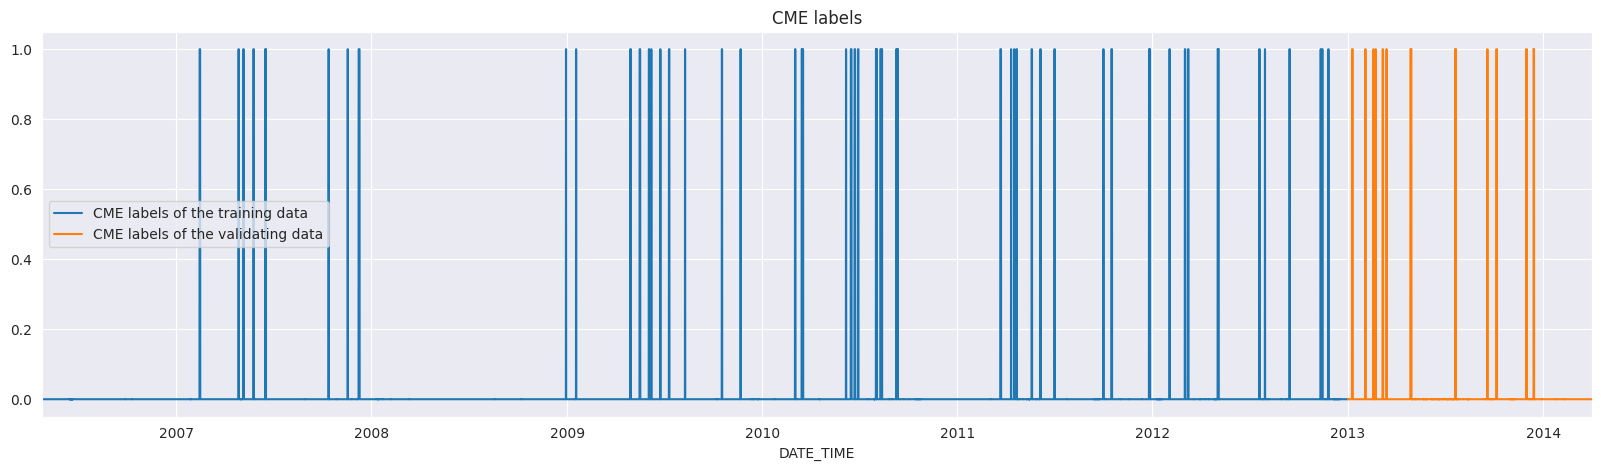

In [6]:
df_train = df.loc[:'2012-12-31'].copy()
df_test = df.loc['2013-01-01':'2014-04-01'].copy()

features = ['BX', 'BY', 'BZ', 'RSC']
label_feature = 'cme'

_, ax = plt.subplots(figsize=(20, 5))
df_train[label_feature].plot(ax=ax, label="CME labels of the training data")
df_test[label_feature].plot(ax=ax, label="CME labels of the validating data")
plt.title("CME labels")
plt.legend()
plt.show()

In [8]:
# Create the feature matrix and the labels
y_tr = df_train[label_feature].values
X_tr = df_train[features].values
y_te = df_test[label_feature].values
X_te = df_test[features].values

# Standardize the data
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)

print("Shape of y:", y_tr.shape)
print("Shape of X:", X_tr.shape)
print("Shape of y_test:", y_te.shape)
print("Shape of X_test:", X_te.shape)

Shape of y: (234624,)
Shape of X: (234624, 4)
Shape of y_test: (43776,)
Shape of X_test: (43776, 4)


## Create the feature sequence for the LSTM model

In [9]:
time_steps = 36  # 9 hours of data
n_features = len(features) # Number of features

X_train, y_train = create_sequences_without_nan(X_tr, y_tr, time_steps)
X_val, y_val = create_sequences_without_nan(X_te, y_te, time_steps)
y_train = (y_train > 0.5).astype(int)
y_val = (y_val > 0.5).astype(int)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(232610, 18, 4) (232610,)
(43258, 18, 4) (43258,)
Check for NaNs:
0
0


## Augment the data of the CME events vy adding noise to tge features sequences

In [11]:
X_train_aug, y_train_aug = augment_data(X_train, y_train, label_to_augment=1, factor=10, std=0.1)
print(X_train_aug.shape, y_train_aug.shape, X_val.shape, y_val.shape)

(274680, 18, 4) (274680,) (54318, 18, 4) (54318,)


# Train and evaluate the LSTM model

## Create the dataloaders and set the batch size

In [9]:
def create_data_loader(X, y, batch_size, shuffle=False):
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32).to(device), torch.tensor(y, dtype=torch.float32).to(device))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Create DataLoaders
batch_size = 128  
train_loader = create_data_loader(X_train_aug, y_train_aug, batch_size, shuffle=True)
val_loader = create_data_loader(X_val, y_val, batch_size)

## Define the LSTM model

In [10]:
class CMEPredictor(nn.Module):
    def __init__(self, n_features, n_hidden=50, n_layers=1, dropout=0.0):
        super(CMEPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=n_hidden, num_layers=n_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(n_hidden, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return torch.sigmoid(x)
    
    
def create_model(n_hidden, n_layers, dropout, pos_weight=None, lr=0.001):
    """
    Create a LSTM model for time series classification
    :param n_hidden: number of nodes in the hidden layer of the LSTM
    :param n_layers: number of layers in the LSTM
    :param dropout: dropout rate in the LSTM [0, 1]
    :param pos_weight: weight of the positibe class
    :param lr: learning rate
    :return: nn.Module (LSTM pytorch model)
    """
    model = CMEPredictor(n_features, n_hidden, n_layers, dropout=dropout).to(device)
    if pos_weight is None:
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_aug), y=y_train_aug)
        pos_weight = class_weights[1] / class_weights[0]
    
    pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float32).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
    return model, optimizer, criterion

In [ ]:
def evaluate_model(model: nn.Module, data_loader: DataLoader):
    """
    Evaluate a trained model
    :param model: trained model
    :param data_loader: data to evaluate the model
    :return: accuracy, f1, precision, recall
    """
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)
            predicted = (outputs > 0.5).float()  # Using 0.5 as the threshold for binary classification
            predictions.extend(predicted.view(-1).tolist())
            true_labels.extend(y_batch.tolist())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    return accuracy, f1, precision, recall

def train_model(model, train_loader, eval_loader, criterion, optimizer, n_epochs):
    """
    Train the model 
    :param model: 
    :param train_loader: training dataset
    :param eval_loader: validation dataset
    :param criterion: Loss function
    :param optimizer: Optimizer for the training
    :param n_epochs: number of epochs (int)
    :return None
    """
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch.view(-1, 1))
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for X_batch, y_batch in eval_loader:
                val_output = model(X_batch)
                val_loss += criterion(val_output, y_batch.view(-1, 1)).item()
        val_loss /= len(eval_loader)
        
        
def train_eval_model(model, train_loader, val_loader, criterion, optimizer, n_epochs):
    """
    Train and evaluate the model
    :return: validation and training scores
    """
    train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs)
    val_scores = evaluate_model(model, val_loader)
    train_scores = evaluate_model(model, train_loader)
    return val_scores, train_scores


## Training parameters for the grid search

In [11]:
n_hidden = [2, 5, 7]
n_layers = [1, 2]
dropout = [0.0, 0.2]
lr = [0.001]
n_epochs = [5, 10]
print("Number of combinations:", len(n_hidden) * len(n_layers) * len(dropout) * len(lr) * len(n_epochs))

## Perform the grid search for the training parameters

In [17]:
train_param_names = ['n_hidden', 'n_layers', 'dropout', 'lr', 'n_epochs']
scores_names = ['accuracy', 'f1', 'precision', 'recall']
train_info_names = train_param_names + scores_names

df_scores = pd.DataFrame(columns=train_info_names)
df_train_scores = pd.DataFrame(columns=train_info_names)

for n_h in n_hidden:
    for n_l in n_layers:
        for d in dropout:
            for l in lr:
                for n_e in n_epochs:
                    train_param = [n_h, n_l, d, l, n_e]
                    print(f"n_hidden: {n_h}, n_layers: {n_l}, dropout: {d}, lr: {l}, n_epochs: {n_e}")
                    model, optimizer, criterion = create_model(n_h, n_l, d, lr=l, pos_weight=None)
                    scores, train_scores = train_eval_model(model, train_loader, val_loader, criterion, optimizer, n_e)
                    data = pd.DataFrame([train_param + scores], columns=train_info_names)
                    data_train = pd.DataFrame([train_param + train_scores], columns=train_info_names)
                    df_scores = pd.concat([df_scores, data], ignore_index=True)
                    df_train_scores = pd.concat([df_train_scores, data_train], ignore_index=True)

Epoch 1, Loss: 0.3222329914569855, Val Loss: 2.4725187190714673
Epoch 2, Loss: 1.479699969291687, Val Loss: 2.5919731775375867
Epoch 3, Loss: 0.18615412712097168, Val Loss: 2.550418381176933
Epoch 4, Loss: 1.979014277458191, Val Loss: 2.5886698423515586
Epoch 5, Loss: 0.16962885856628418, Val Loss: 2.4995867186198395
Epoch 6, Loss: 0.1328626275062561, Val Loss: 2.494243359931651
Epoch 7, Loss: 0.39092761278152466, Val Loss: 2.540540186126204
Epoch 8, Loss: 1.1048771142959595, Val Loss: 2.5305980269703463
Epoch 9, Loss: 1.2067769765853882, Val Loss: 2.555299377840387
Epoch 10, Loss: 0.9098678231239319, Val Loss: 2.53838477099656


In [ ]:
print(df_scores)
print(df_train_scores)
df_scores.to_csv("DATA/training_data/grid_search.csv")  # Save the results of the grid search

# Get the parameters of the best model

In [ ]:
df_scores = pd.read_csv('gris_search.csv', index_col=0)
sorted_df = df_scores.sort_values('f1',ascending=False)
best_model = sorted_df.iloc[0, train_param_names]
print(f"The best mode has parameters {best_model}")